In [1]:
# environment set up
import keras
from keras.models import Sequential
from keras.layers import Reshape, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.utils import to_categorical
import tensorflow as tf # only use tensorflow keras
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import pandas as pd

# local
import spectra_ml     #make sure path is specified in computer
from spectra_ml import metrics

# working folder
directory = "C:/Users/Bonita/Documents/GitHub/spectra-ml/data"
os.chdir(directory)

# print(os.getcwd())

Using TensorFlow backend.


In [2]:
# dataset = str(directory + "/dataset3")
# num_samples = len([name for name in os.listdir(dataset) if \
#                    os.path.isfile(os.path.join(dataset,name))])

# print(num_samples)

In [3]:
stddata_path = directory+"/ASCIIdata_splib07a.standardized"
metadata = pd.read_csv(stddata_path+"/spectra-metadata.csv", sep="|")
metadata.head()

spectrum_id   value_type                      material  \
0        18244  reflectance  Alizarin_crimson (dk) GDS780   
1        18253  reflectance         Aluminum brushed 293K   
2        18262  reflectance       Ammonium_Chloride GDS77   
3        18269  reflectance  Asphalt GDS376 Blck_Road old   
4        18278  reflectance    Asphalt_Shingle GDS366 Tan   

  spectrometer_purity_code measurement_type  \
0                   ASDFRa             AREF   
1                   ASDFRa             AREF   
2                    BECKa             AREF   
3                   ASDFRa             AREF   
4                   ASDFRa             AREF   

                                       raw_data_path  
0  ChapterA_ArtificialMaterials\splib07a_Alizarin...  
1  ChapterA_ArtificialMaterials\splib07a_Aluminum...  
2  ChapterA_ArtificialMaterials\splib07a_Ammonium...  
3  ChapterA_ArtificialMaterials\splib07a_Asphalt_...  
4  ChapterA_ArtificialMaterials\splib07a_Asphalt_...

In [4]:
def find_record(string):
    ind = string.find("|")
    return string[:ind]

metadata = metadata[metadata['value_type'] == "reflectance"]
metadata = metadata[~metadata['spectrometer_purity_code'].str.contains("NIC4")]

In [5]:
data = metadata.iloc[0]
type(data)

metadata[metadata["material"].str.match("Chlor")].shape[0]

26

In [6]:
record_nums = []
y = []
spectrum_names = []

act = 0
aln = 0
chl = 0

for i in range(metadata.shape[0]):
    data = metadata.iloc[i, :]
    if data[2].find("Actinolite") != -1: # if material name contains actinolite
        record_nums.append(data[0])
        y.append(int(0))
        spectrum_names.append("Actinolite")
        act += 1
    elif data[2].find("Alun") != -1:
        record_nums.append(data[0])
        y.append(int(1))
        spectrum_names.append("Alunite")
        aln += 1
    elif (data[2].find("Chlorit") != -1 or data[2].find("Chlor.") != -1 or data[2].find("Chlor+") != -1 or data[2].find("Chl.") != -1):
        record_nums.append(data[0])
        y.append(int(2))
        spectrum_names.append("Chlorite")
        chl += 1

y = np.reshape(y, (len(y), 1))
num_samples = len(record_nums)
print(num_samples)
print(len(y))
print(type(y))
print(act)
print(aln)
print(chl)

76
76
<class 'numpy.ndarray'>
19
32
25


In [7]:
spectrum_len = 1000
spectra = np.zeros((num_samples,spectrum_len))
wavelengths = np.zeros((1,spectrum_len))

# y = np.zeros((num_samples, 1))

In [8]:
# import shutil

# for num in actinolite:
#     shutil.copy2(stddata_path+"/{}.csv".format(num), directory+"/Std_Actinolite")
# for num in alunite:
#     shutil.copy2(stddata_path+"/{}.csv".format(num), directory+"/Std_Alunite")
# for num in chlorite:
#     shutil.copy2(stddata_path+"/{}.csv".format(num), directory+"/Std_Chlorite")

In [9]:
# debug cell 
# for cell below

#data = pd.read_csv(stddata_path+"/{}.csv".format(record_nums[i]))
#print(data)

In [10]:
num_neg = 0
for i in range(num_samples):
    hasnegative = False
    data = pd.read_csv(stddata_path+"/{}.csv".format(record_nums[i]))
    if i == 0:
        print(data.iloc[0,:])
        wavelengths[i,:] = data.iloc[:, 0].values
    spectra[i,:] = data.iloc[:, 1].values
    for j in range(spectrum_len):
        if spectra[i,j] < 0:
            hasnegative = True
            spectra[i,j] = 0
    if hasnegative:
        print(record_nums[i])
        num_neg += 1
# print(num_neg)
# wavelengths
# print(record_nums[43])
# print(spectra[43])

wavelength     0.370000
reflectance    0.366252
Name: 0, dtype: float64


In [11]:
# spectrum_len = 480
# spectra = np.zeros((num_samples,spectrum_len))

# spectrum_categories = np.zeros(num_samples)
# first_record_of_mixtures_chapter = 11602
# is_a_mineral = 1                                   # these numbers match the chapter numbers given by usgs
# is_a_mixture = 2
# spectrum_names = ["" for x in range(num_samples)]

# y = np.zeros((num_samples, 1))

# os.chdir(dataset)

# i = 0

# for filename in os.listdir(dataset):
#     file_object  = open(filename, 'r').readlines()
# #     strip off header, add to matrix 'spectra'
#     spectra[i,:] = file_object[1:]

# #     label spectrum class, based on header
# #     actinolite: 0, alunite: 1, chlorite: 2
#     material_name = file_object[0]
    
#     spectrum_names[i] = material_name
    
#     start = 'Record='
#     end = ':'
#     record_number = int((material_name.split(start))[1].split(end)[0])
#     # print(record_number)
#     if record_number < first_record_of_mixtures_chapter:
#         spectrum_categories[i] = is_a_mineral
#     else:
#         spectrum_categories[i] = is_a_mixture

# #     print(material_name)

#     if material_name.find('Actinolite',) != -1: # if material name contains actinolite
#         y[i,0] = 0
#     elif material_name.find('Alun',)!= -1:
#         y[i,0] = 1
#     else: # chlorite
#         y[i,0] = 2

# #     turn missing points into 0
#     for j in range(spectrum_len):
#         if spectra[i,j] < 0:
#             spectra[i,j] = 0
#     i+=1

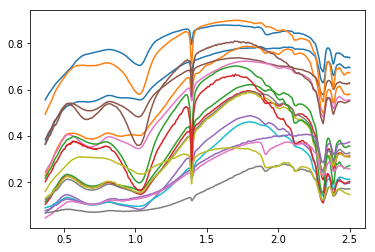

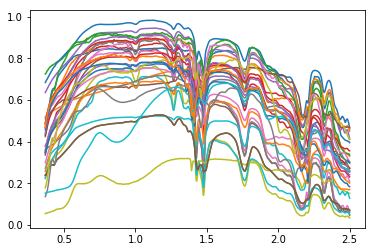

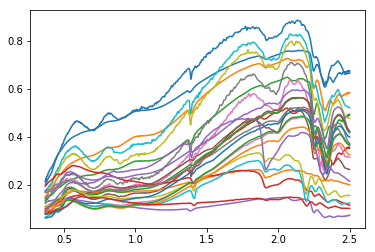

In [12]:
# --- plot the classes

# plot each class in a separate plot
# plot spectra names in legend
# plot minerals and mixtures w diff line widths

mineral_names = ["Actinolite", "Alunite", "Chlorite"]

# variables
num0 = 0 #number of samples of class 0
num1 = 0
num2 = 0

mineral_linewidth = 1         # linewidth = 1 is default
mixture_linewidth = 3         

# count the number of each class to make spectra0, spectra1, spectra2 databases
for i in range(num_samples):
    if y[i,0]== 0:
        num0 += 1
    elif y[i,0]== 1:
        num1 += 1
    elif y[i,0]== 2:
        num2 += 1

# make class-specific databases spectra0, ...1, ...2
spectra0 = np.zeros((num0,spectrum_len)) 
spectra1 = np.zeros((num1,spectrum_len)) 
spectra2 = np.zeros((num2,spectrum_len)) 

labels0 = ["" for x in range(num0)]
labels1 = ["" for x in range(num1)]
labels2 = ["" for x in range(num2)]

linewidth0 = np.zeros(num0)
linewidth1 = np.zeros(num1)
linewidth2 = np.zeros(num2)


# make counters for each database to place spectra
i0 = 0
i1 = 0
i2 = 0

# set linewidth for the spectrum 
# populate class-specific databases spectra0, ...1, ...2
for i in range(num_samples):
    
    # set linewidth
    #testcode
    #print(spectrum_categories)
    #print(spectrum_categories[i])
    
#     if spectrum_categories[i] == is_a_mineral:
#         linewidth = mineral_linewidth
        
#         #testcode
#         #print('min')
#     else: 
#         linewidth = mixture_linewidth
    linewidth = 2
        
        #testcode
        #print('mix')
    
    # populate matrices for making each class plot
    if y[i,0]== 0:
        spectra0[i0,:] = spectra[i,:]
        labels0[i0] = spectrum_names[i]
        linewidth0[i0] = linewidth
        i0 +=1
    elif y[i,0]== 1:
        spectra1[i1,:] = spectra[i,:]
        labels1[i1] = spectrum_names[i]
        linewidth1[i1] = linewidth
        i1 +=1
    else:
        spectra2[i2,:] = spectra[i,:]
        labels2[i2] = spectrum_names[i]
        linewidth2[i2] = linewidth
        i2 +=1

# plot each class-specific database separately
for i in range(i0):
#     fig = plt.figure()
#     plt.plot(range(1, spectrum_len+1), spectra0[i,:], label = labels0[i], linewidth = linewidth0[i]) # remove linewidth for all mixtures/minerals to be standard
    plt.plot(wavelengths[0,:], spectra0[i,:]) # remove linewidth for all mixtures/minerals to be standard
#     plt.xticks([])
#     plt.yticks([])
#     plt.show()
#     path = "/Users/Srikar/Desktop/Velexi/spectra-ml/lab-notebook/smunukutla/plots/" + mineral_names[0] + str(i) + ".png"
#     fig.savefig(path, format = "PNG")
# plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

for i in range(i1):
#     plt.plot(range(1, spectrum_len+1), spectra1[i,:], label = labels1[i], linewidth = linewidth1[i])
    plt.plot(wavelengths[0,:], spectra1[i,:])
# plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

for i in range(i2):
#     plt.plot(range(1, spectrum_len+1), spectra2[i,:], label = labels2[i], linewidth = linewidth2[i])
    plt.plot(wavelengths[0,:], spectra2[i,:])
# plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

In [13]:
sample_indices = list(range(0, num_samples))
print(num_samples)
random.shuffle(sample_indices)
train_set_size = 3*(num_samples//5)
dev_set_size = (num_samples//5)
test_set_size= num_samples-dev_set_size - train_set_size
print(train_set_size)
print(test_set_size)
print(dev_set_size)
train_set_indices = sample_indices[:train_set_size]
dev_set_indices = sample_indices[train_set_size: train_set_size+dev_set_size]
test_set_indices= sample_indices[train_set_size+dev_set_size: num_samples]
print(train_set_indices)
print(test_set_indices)
print(dev_set_indices)

train_set = spectra[train_set_indices, :]
train_labels = y[train_set_indices, :]
dev_set = spectra[dev_set_indices, :]
dev_labels = y[dev_set_indices, :]
test_set = spectra[test_set_indices, :]
test_labels = y[test_set_indices, :]

76
45
16
15
[50, 13, 10, 61, 53, 63, 9, 37, 26, 29, 51, 5, 44, 31, 62, 58, 30, 40, 74, 32, 67, 66, 48, 36, 59, 65, 49, 71, 75, 35, 56, 1, 39, 60, 68, 42, 34, 16, 43, 7, 38, 8, 14, 64, 33]
[20, 72, 11, 41, 28, 12, 55, 52, 69, 45, 54, 2, 21, 18, 25, 19]
[4, 57, 47, 17, 6, 23, 70, 22, 0, 24, 15, 46, 27, 73, 3]


In [14]:
train_labels = train_labels.flatten()
dev_labels = dev_labels.flatten()
test_labels = test_labels.flatten()
# type(train_labels)

In [15]:
# len(train_set)
# len(train_set[17])
print(test_set.shape)

(16, 1000)


In [16]:
train_set = np.reshape(train_set, (train_set.shape[0], spectrum_len, 1))
dev_set = np.reshape(dev_set, (dev_set.shape[0], spectrum_len, 1))
test_set = np.reshape(test_set, (test_set.shape[0], spectrum_len, 1))


print(train_labels)
train_labels = np.reshape(train_labels, (train_labels.shape[0], 1))
dev_labels = np.reshape(dev_labels, (dev_labels.shape[0], 1))
test_labels = np.reshape(test_labels, (test_labels.shape[0], 1))


train_labels = to_categorical(train_labels)
dev_labels = to_categorical(dev_labels)
test_labels = to_categorical(test_labels)

[1 0 0 2 1 2 0 2 1 2 1 0 1 2 2 1 2 0 1 2 2 2 1 2 1 2 1 2 1 2 1 0 2 2 2 0 2
 1 1 0 2 0 0 2 2]


In [17]:
#print(train_labels)

In [18]:
print(train_set.shape[1])


model = Sequential()
# model.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model.add(Conv1D(64, 25, activation='relu', input_shape=(train_set.shape[1], 1)))
model.add(Conv1D(64, 25, activation='relu'))
model.add(MaxPooling1D(4)) # 108 by 64 so far
model.add(Conv1D(100, 25, activation='relu'))
model.add(Conv1D(100, 25, activation='relu'))
model.add(MaxPooling1D(4))
# model.add(Dropout(0.5))
# model.add(GlobalAveragePooling1D())
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
print(model.summary())

1000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 976, 64)           1664      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 952, 64)           102464    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 238, 64)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 214, 100)          160100    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 190, 100)          250100    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 47, 100)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4700)              0         
_____

In [19]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 12
EPOCHS = 50

print(train_labels.shape)
#model.fit(train_set, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, \
            #verbose=1, validation_data=(dev_set, dev_labels))
History = model.fit(train_set, train_labels, batch_size=BATCH_SIZE, \
                    epochs=EPOCHS, verbose=1, validation_data=(dev_set, dev_labels)) 

(45, 3)
Train on 45 samples, validate on 15 samples
Epoch 1/50
45/45 [==============================] - 2s 39ms/step - loss: 1.1146 - acc: 0.4000 - val_loss: 1.0662 - val_acc: 0.3333
Epoch 2/50
45/45 [==============================] - 1s 23ms/step - loss: 1.0073 - acc: 0.6000 - val_loss: 0.8580 - val_acc: 0.6667
Epoch 3/50
45/45 [==============================] - 1s 23ms/step - loss: 0.7597 - acc: 0.5778 - val_loss: 0.6005 - val_acc: 0.6667
Epoch 4/50
45/45 [==============================] - 1s 23ms/step - loss: 0.6663 - acc: 0.7111 - val_loss: 0.6224 - val_acc: 0.6667
Epoch 5/50
45/45 [==============================] - 1s 23ms/step - loss: 0.6246 - acc: 0.6667 - val_loss: 0.3851 - val_acc: 0.7333
Epoch 6/50
45/45 [==============================] - 1s 22ms/step - loss: 0.5567 - acc: 0.7333 - val_loss: 0.5741 - val_acc: 0.6667
Epoch 7/50
45/45 [==============================] - 1s 23ms/step - loss: 0.4791 - acc: 0.7778 - val_loss: 0.3599 - val_acc: 0.8000
Epoch 8/50
45/45 [=============

In [20]:
y_pred = model.predict(test_set)
#y_pred

In [21]:
#test_labels

In [22]:
model.evaluate(test_set, test_labels)

16/16 [==============================] - 0s 6ms/step


[1.5281782150268555, 0.875]

In [23]:
# use bootstrap(model, data, data_labels, num_epochs, batch_size, num_bootstrap_runs)
num_epochs = EPOCHS
batch_size = BATCH_SIZE
num_bootstrap_runs = 100

##
train_set_labels = train_labels
dev_set_labels = dev_labels
#History = model.fit(train_set, train_set_labels, batch_size=BATCH_SIZE,\
         #epochs=EPOCHS, verbose=1, validation_data=(dev_set, dev_set_labels))
##

bresults = spectra_ml.metrics.bootstrap(model, spectra, y, num_epochs, batch_size, num_bootstrap_runs)
print(bresults)

Train on 46 samples, validate on 15 samples
Epoch 1/50
46/46 [==============================] - 1s 24ms/step - loss: 0.9391 - acc: 0.9130 - val_loss: 0.5101 - val_acc: 0.9333
Epoch 2/50
46/46 [==============================] - 1s 24ms/step - loss: 1.0363 - acc: 0.8696 - val_loss: 0.0186 - val_acc: 1.0000
Epoch 3/50
46/46 [==============================] - 1s 24ms/step - loss: 1.0166 - acc: 0.8696 - val_loss: 0.1697 - val_acc: 0.8667
Epoch 4/50
46/46 [==============================] - 1s 24ms/step - loss: 0.6511 - acc: 0.8261 - val_loss: 0.1079 - val_acc: 0.9333
Epoch 5/50
46/46 [==============================] - 1s 24ms/step - loss: 0.1640 - acc: 0.8913 - val_loss: 0.1131 - val_acc: 0.9333
Epoch 6/50
46/46 [==============================] - 1s 24ms/step - loss: 0.1763 - acc: 0.9348 - val_loss: 0.1242 - val_acc: 0.9333
Epoch 7/50
46/46 [==============================] - 1s 24ms/step - loss: 0.1637 - acc: 0.9348 - val_loss: 0.0767 - val_acc: 1.0000
Epoch 8/50
46/46 [=====================

46/46 [==============================] - 1s 24ms/step - loss: 1.6185e-04 - acc: 1.0000 - val_loss: 0.2571 - val_acc: 0.8667
Epoch 12/50
46/46 [==============================] - 1s 24ms/step - loss: 1.5400e-04 - acc: 1.0000 - val_loss: 0.2457 - val_acc: 0.8667
Epoch 13/50
46/46 [==============================] - 1s 24ms/step - loss: 1.4794e-04 - acc: 1.0000 - val_loss: 0.2370 - val_acc: 0.8667
Epoch 14/50
46/46 [==============================] - 1s 24ms/step - loss: 1.4275e-04 - acc: 1.0000 - val_loss: 0.2293 - val_acc: 0.8667
Epoch 15/50
46/46 [==============================] - 1s 24ms/step - loss: 1.4011e-04 - acc: 1.0000 - val_loss: 0.2205 - val_acc: 0.8667
Epoch 16/50
46/46 [==============================] - 1s 24ms/step - loss: 1.3420e-04 - acc: 1.0000 - val_loss: 0.2134 - val_acc: 0.8667
Epoch 17/50
46/46 [==============================] - 1s 24ms/step - loss: 1.2852e-04 - acc: 1.0000 - val_loss: 0.2076 - val_acc: 0.8667
Epoch 18/50
46/46 [==============================] - 1s 24ms

Epoch 21/50
46/46 [==============================] - 1s 24ms/step - loss: 3.8088e-04 - acc: 1.0000 - val_loss: 0.1710 - val_acc: 0.9333
Epoch 22/50
46/46 [==============================] - 1s 23ms/step - loss: 3.7058e-04 - acc: 1.0000 - val_loss: 0.1946 - val_acc: 0.9333
Epoch 23/50
46/46 [==============================] - 1s 24ms/step - loss: 3.5452e-04 - acc: 1.0000 - val_loss: 0.2024 - val_acc: 0.9333
Epoch 24/50
46/46 [==============================] - 1s 25ms/step - loss: 3.3946e-04 - acc: 1.0000 - val_loss: 0.1962 - val_acc: 0.9333
Epoch 25/50
46/46 [==============================] - 1s 25ms/step - loss: 3.2767e-04 - acc: 1.0000 - val_loss: 0.1885 - val_acc: 0.9333
Epoch 26/50
46/46 [==============================] - 1s 25ms/step - loss: 3.1713e-04 - acc: 1.0000 - val_loss: 0.1802 - val_acc: 0.9333
Epoch 27/50
46/46 [==============================] - 1s 25ms/step - loss: 3.1120e-04 - acc: 1.0000 - val_loss: 0.1911 - val_acc: 0.9333
Epoch 28/50
46/46 [=============================

46/46 [==============================] - 1s 24ms/step - loss: 5.0431e-05 - acc: 1.0000 - val_loss: 0.2664 - val_acc: 0.9333
Epoch 31/50
46/46 [==============================] - 1s 26ms/step - loss: 4.9563e-05 - acc: 1.0000 - val_loss: 0.2677 - val_acc: 0.9333
Epoch 32/50
46/46 [==============================] - 1s 27ms/step - loss: 4.8710e-05 - acc: 1.0000 - val_loss: 0.2688 - val_acc: 0.9333
Epoch 33/50
46/46 [==============================] - 1s 24ms/step - loss: 4.7846e-05 - acc: 1.0000 - val_loss: 0.2714 - val_acc: 0.9333
Epoch 34/50
46/46 [==============================] - 1s 24ms/step - loss: 4.6967e-05 - acc: 1.0000 - val_loss: 0.2740 - val_acc: 0.9333
Epoch 35/50
46/46 [==============================] - 1s 24ms/step - loss: 4.6250e-05 - acc: 1.0000 - val_loss: 0.2743 - val_acc: 0.9333
Epoch 36/50
46/46 [==============================] - 1s 24ms/step - loss: 4.5463e-05 - acc: 1.0000 - val_loss: 0.2751 - val_acc: 0.9333
Epoch 37/50
46/46 [==============================] - 1s 24ms

46/46 [==============================] - 1s 24ms/step - loss: 4.7378e-05 - acc: 1.0000 - val_loss: 0.8362 - val_acc: 0.9333
Epoch 40/50
46/46 [==============================] - 1s 24ms/step - loss: 4.6711e-05 - acc: 1.0000 - val_loss: 0.8413 - val_acc: 0.9333
Epoch 41/50
46/46 [==============================] - 1s 24ms/step - loss: 4.5986e-05 - acc: 1.0000 - val_loss: 0.8460 - val_acc: 0.9333
Epoch 42/50
46/46 [==============================] - 1s 24ms/step - loss: 4.4862e-05 - acc: 1.0000 - val_loss: 0.8477 - val_acc: 0.9333
Epoch 43/50
46/46 [==============================] - 1s 25ms/step - loss: 4.4393e-05 - acc: 1.0000 - val_loss: 0.8524 - val_acc: 0.9333
Epoch 44/50
46/46 [==============================] - 1s 25ms/step - loss: 4.3419e-05 - acc: 1.0000 - val_loss: 0.8535 - val_acc: 0.9333
Epoch 45/50
46/46 [==============================] - 1s 25ms/step - loss: 4.2579e-05 - acc: 1.0000 - val_loss: 0.8554 - val_acc: 0.9333
Epoch 46/50
46/46 [==============================] - 1s 25ms

46/46 [==============================] - 1s 26ms/step - loss: 1.4565e-05 - acc: 1.0000 - val_loss: 0.1777 - val_acc: 0.9333
Epoch 49/50
46/46 [==============================] - 1s 26ms/step - loss: 1.4402e-05 - acc: 1.0000 - val_loss: 0.1782 - val_acc: 0.9333
Epoch 50/50
15/15 [==============================] - 0s 7ms/step
Train on 46 samples, validate on 15 samples
Epoch 1/50
46/46 [==============================] - 1s 26ms/step - loss: 1.2829e-04 - acc: 1.0000 - val_loss: 0.2049 - val_acc: 0.9333
Epoch 2/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1804e-04 - acc: 1.0000 - val_loss: 0.3050 - val_acc: 0.9333
Epoch 3/50
46/46 [==============================] - 1s 25ms/step - loss: 7.7855e-05 - acc: 1.0000 - val_loss: 0.3905 - val_acc: 0.9333
Epoch 4/50
46/46 [==============================] - 1s 25ms/step - loss: 6.6316e-05 - acc: 1.0000 - val_loss: 0.4759 - val_acc: 0.9333
Epoch 5/50
46/46 [==============================] - 1s 25ms/step - loss: 5.3381e-05 - acc: 

46/46 [==============================] - 1s 25ms/step - loss: 1.0024e-05 - acc: 1.0000 - val_loss: 0.7109 - val_acc: 0.9333
Epoch 8/50
46/46 [==============================] - 1s 25ms/step - loss: 9.9890e-06 - acc: 1.0000 - val_loss: 0.7034 - val_acc: 0.9333
Epoch 9/50
46/46 [==============================] - 1s 25ms/step - loss: 9.3630e-06 - acc: 1.0000 - val_loss: 0.6989 - val_acc: 0.9333
Epoch 10/50
46/46 [==============================] - 1s 25ms/step - loss: 9.2631e-06 - acc: 1.0000 - val_loss: 0.6933 - val_acc: 0.9333
Epoch 11/50
46/46 [==============================] - 1s 27ms/step - loss: 9.0609e-06 - acc: 1.0000 - val_loss: 0.6883 - val_acc: 0.9333
Epoch 12/50
46/46 [==============================] - 1s 28ms/step - loss: 8.8030e-06 - acc: 1.0000 - val_loss: 0.6845 - val_acc: 0.9333
Epoch 13/50
46/46 [==============================] - 1s 25ms/step - loss: 8.4660e-06 - acc: 1.0000 - val_loss: 0.6840 - val_acc: 0.9333
Epoch 14/50
46/46 [==============================] - 1s 25ms/s

Epoch 17/50
46/46 [==============================] - 1s 25ms/step - loss: 7.4327e-06 - acc: 1.0000 - val_loss: 0.4962 - val_acc: 0.9333
Epoch 18/50
46/46 [==============================] - 1s 26ms/step - loss: 7.3290e-06 - acc: 1.0000 - val_loss: 0.4895 - val_acc: 0.9333
Epoch 19/50
46/46 [==============================] - 1s 29ms/step - loss: 7.3031e-06 - acc: 1.0000 - val_loss: 0.4812 - val_acc: 0.9333
Epoch 20/50
46/46 [==============================] - 1s 28ms/step - loss: 7.1424e-06 - acc: 1.0000 - val_loss: 0.4751 - val_acc: 0.9333
Epoch 21/50
46/46 [==============================] - 1s 27ms/step - loss: 7.0647e-06 - acc: 1.0000 - val_loss: 0.4694 - val_acc: 0.9333
Epoch 22/50
46/46 [==============================] - 1s 26ms/step - loss: 6.9934e-06 - acc: 1.0000 - val_loss: 0.4636 - val_acc: 0.9333
Epoch 23/50
46/46 [==============================] - 1s 28ms/step - loss: 6.9493e-06 - acc: 1.0000 - val_loss: 0.4572 - val_acc: 0.9333
Epoch 24/50
46/46 [=============================

46/46 [==============================] - 1s 25ms/step - loss: 1.4462e-05 - acc: 1.0000 - val_loss: 0.5518 - val_acc: 0.9333
Epoch 27/50
46/46 [==============================] - 1s 27ms/step - loss: 1.4343e-05 - acc: 1.0000 - val_loss: 0.5516 - val_acc: 0.9333
Epoch 28/50
46/46 [==============================] - 1s 27ms/step - loss: 1.4294e-05 - acc: 1.0000 - val_loss: 0.5533 - val_acc: 0.9333
Epoch 29/50
46/46 [==============================] - 1s 26ms/step - loss: 1.4145e-05 - acc: 1.0000 - val_loss: 0.5534 - val_acc: 0.9333
Epoch 30/50
46/46 [==============================] - 1s 26ms/step - loss: 1.4056e-05 - acc: 1.0000 - val_loss: 0.5540 - val_acc: 0.9333
Epoch 31/50
46/46 [==============================] - 1s 26ms/step - loss: 1.3955e-05 - acc: 1.0000 - val_loss: 0.5552 - val_acc: 0.9333
Epoch 32/50
46/46 [==============================] - 1s 26ms/step - loss: 1.3883e-05 - acc: 1.0000 - val_loss: 0.5559 - val_acc: 0.9333
Epoch 33/50
46/46 [==============================] - 1s 27ms

46/46 [==============================] - 1s 26ms/step - loss: 2.4604e-05 - acc: 1.0000 - val_loss: 1.0749 - val_acc: 0.9333
Epoch 36/50
46/46 [==============================] - 1s 25ms/step - loss: 2.4301e-05 - acc: 1.0000 - val_loss: 1.0749 - val_acc: 0.9333
Epoch 37/50
46/46 [==============================] - 1s 26ms/step - loss: 2.3917e-05 - acc: 1.0000 - val_loss: 1.0749 - val_acc: 0.9333
Epoch 38/50
46/46 [==============================] - 1s 25ms/step - loss: 2.3627e-05 - acc: 1.0000 - val_loss: 1.0749 - val_acc: 0.9333
Epoch 39/50
46/46 [==============================] - 1s 26ms/step - loss: 2.3477e-05 - acc: 1.0000 - val_loss: 1.0749 - val_acc: 0.9333
Epoch 40/50
46/46 [==============================] - 1s 25ms/step - loss: 2.3096e-05 - acc: 1.0000 - val_loss: 1.0749 - val_acc: 0.9333
Epoch 41/50
46/46 [==============================] - 1s 25ms/step - loss: 2.2746e-05 - acc: 1.0000 - val_loss: 1.0749 - val_acc: 0.9333
Epoch 42/50
46/46 [==============================] - 1s 26ms

46/46 [==============================] - 1s 28ms/step - loss: 8.8727e-06 - acc: 1.0000 - val_loss: 0.9331 - val_acc: 0.9333
Epoch 45/50
46/46 [==============================] - 1s 26ms/step - loss: 8.7366e-06 - acc: 1.0000 - val_loss: 0.9297 - val_acc: 0.9333
Epoch 46/50
46/46 [==============================] - 1s 27ms/step - loss: 8.7159e-06 - acc: 1.0000 - val_loss: 0.9246 - val_acc: 0.9333
Epoch 47/50
46/46 [==============================] - 1s 26ms/step - loss: 8.7120e-06 - acc: 1.0000 - val_loss: 0.9349 - val_acc: 0.9333
Epoch 48/50
46/46 [==============================] - 1s 26ms/step - loss: 8.5837e-06 - acc: 1.0000 - val_loss: 0.9379 - val_acc: 0.9333
Epoch 49/50
46/46 [==============================] - 1s 26ms/step - loss: 8.5591e-06 - acc: 1.0000 - val_loss: 0.9318 - val_acc: 0.9333
Epoch 50/50
15/15 [==============================] - 0s 7ms/step
Train on 46 samples, validate on 15 samples
Epoch 1/50
46/46 [==============================] - 1s 26ms/step - loss: 1.6871e-05 - a

Epoch 3/50
46/46 [==============================] - 1s 27ms/step - loss: 6.5763e-06 - acc: 1.0000 - val_loss: 1.0749 - val_acc: 0.9333
Epoch 4/50
46/46 [==============================] - 1s 26ms/step - loss: 6.3249e-06 - acc: 1.0000 - val_loss: 1.0749 - val_acc: 0.9333
Epoch 5/50
46/46 [==============================] - 1s 26ms/step - loss: 6.1434e-06 - acc: 1.0000 - val_loss: 1.0750 - val_acc: 0.9333
Epoch 6/50
46/46 [==============================] - 1s 27ms/step - loss: 5.8674e-06 - acc: 1.0000 - val_loss: 1.0750 - val_acc: 0.9333
Epoch 7/50
46/46 [==============================] - 1s 26ms/step - loss: 5.8415e-06 - acc: 1.0000 - val_loss: 1.0750 - val_acc: 0.9333
Epoch 8/50
46/46 [==============================] - 1s 26ms/step - loss: 5.6251e-06 - acc: 1.0000 - val_loss: 1.0750 - val_acc: 0.9333
Epoch 9/50
46/46 [==============================] - 1s 26ms/step - loss: 5.6004e-06 - acc: 1.0000 - val_loss: 1.0750 - val_acc: 0.9333
Epoch 10/50
46/46 [==============================] - 1s

46/46 [==============================] - 1s 26ms/step - loss: 3.5647e-06 - acc: 1.0000 - val_loss: 0.7555 - val_acc: 0.9333
Epoch 13/50
46/46 [==============================] - 1s 25ms/step - loss: 3.5362e-06 - acc: 1.0000 - val_loss: 0.7552 - val_acc: 0.9333
Epoch 14/50
46/46 [==============================] - 1s 26ms/step - loss: 3.5012e-06 - acc: 1.0000 - val_loss: 0.7553 - val_acc: 0.9333
Epoch 15/50
46/46 [==============================] - 1s 25ms/step - loss: 3.4688e-06 - acc: 1.0000 - val_loss: 0.7560 - val_acc: 0.9333
Epoch 16/50
46/46 [==============================] - 1s 25ms/step - loss: 3.4442e-06 - acc: 1.0000 - val_loss: 0.7586 - val_acc: 0.9333
Epoch 17/50
46/46 [==============================] - 1s 26ms/step - loss: 3.4208e-06 - acc: 1.0000 - val_loss: 0.7597 - val_acc: 0.9333
Epoch 18/50
46/46 [==============================] - 1s 25ms/step - loss: 3.3846e-06 - acc: 1.0000 - val_loss: 0.7584 - val_acc: 0.9333
Epoch 19/50
46/46 [==============================] - 1s 26ms

46/46 [==============================] - 1s 25ms/step - loss: 1.5601e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 22/50
46/46 [==============================] - 1s 26ms/step - loss: 1.5497e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 23/50
46/46 [==============================] - 1s 25ms/step - loss: 1.5497e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 24/50
46/46 [==============================] - 1s 26ms/step - loss: 1.5290e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 25/50
46/46 [==============================] - 1s 25ms/step - loss: 1.5264e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 26/50
46/46 [==============================] - 1s 26ms/step - loss: 1.5225e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 27/50
46/46 [==============================] - 1s 26ms/step - loss: 1.5122e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 28/50
46/46 [==============================] - 1s 26ms

46/46 [==============================] - 1s 26ms/step - loss: 2.2443e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 31/50
46/46 [==============================] - 1s 26ms/step - loss: 2.2365e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 32/50
46/46 [==============================] - 1s 25ms/step - loss: 2.2313e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 33/50
46/46 [==============================] - 1s 25ms/step - loss: 2.2158e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 34/50
46/46 [==============================] - 1s 26ms/step - loss: 2.2015e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 35/50
46/46 [==============================] - 1s 26ms/step - loss: 2.1963e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 36/50
46/46 [==============================] - 1s 25ms/step - loss: 2.1678e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 37/50
46/46 [==============================] - 1s 26ms

46/46 [==============================] - 1s 26ms/step - loss: 2.6019e-06 - acc: 1.0000 - val_loss: 0.7579 - val_acc: 0.9333
Epoch 40/50
46/46 [==============================] - 1s 26ms/step - loss: 2.5941e-06 - acc: 1.0000 - val_loss: 0.7582 - val_acc: 0.9333
Epoch 41/50
46/46 [==============================] - 1s 26ms/step - loss: 2.5721e-06 - acc: 1.0000 - val_loss: 0.7577 - val_acc: 0.9333
Epoch 42/50
46/46 [==============================] - 1s 26ms/step - loss: 2.5630e-06 - acc: 1.0000 - val_loss: 0.7589 - val_acc: 0.9333
Epoch 43/50
46/46 [==============================] - 1s 26ms/step - loss: 2.5475e-06 - acc: 1.0000 - val_loss: 0.7585 - val_acc: 0.9333
Epoch 44/50
46/46 [==============================] - 1s 26ms/step - loss: 2.5332e-06 - acc: 1.0000 - val_loss: 0.7593 - val_acc: 0.9333
Epoch 45/50
46/46 [==============================] - 1s 26ms/step - loss: 2.5203e-06 - acc: 1.0000 - val_loss: 0.7596 - val_acc: 0.9333
Epoch 46/50
46/46 [==============================] - 1s 26ms

46/46 [==============================] - 1s 26ms/step - loss: 1.3554e-06 - acc: 1.0000 - val_loss: 0.7069 - val_acc: 0.9333
Epoch 49/50
46/46 [==============================] - 1s 27ms/step - loss: 1.3476e-06 - acc: 1.0000 - val_loss: 0.7066 - val_acc: 0.9333
Epoch 50/50
15/15 [==============================] - 0s 7ms/step
Train on 46 samples, validate on 15 samples
Epoch 1/50
46/46 [==============================] - 1s 26ms/step - loss: 2.9025e-06 - acc: 1.0000 - val_loss: 0.7067 - val_acc: 0.9333
Epoch 2/50
46/46 [==============================] - 1s 26ms/step - loss: 2.8960e-06 - acc: 1.0000 - val_loss: 0.7068 - val_acc: 0.9333
Epoch 3/50
46/46 [==============================] - 1s 26ms/step - loss: 2.8805e-06 - acc: 1.0000 - val_loss: 0.7072 - val_acc: 0.9333
Epoch 4/50
46/46 [==============================] - 1s 26ms/step - loss: 2.8597e-06 - acc: 1.0000 - val_loss: 0.7077 - val_acc: 0.9333
Epoch 5/50
46/46 [==============================] - 1s 26ms/step - loss: 2.8507e-06 - acc: 

46/46 [==============================] - 1s 27ms/step - loss: 1.0599e-06 - acc: 1.0000 - val_loss: 0.7585 - val_acc: 0.9333
Epoch 8/50
46/46 [==============================] - 1s 27ms/step - loss: 1.0457e-06 - acc: 1.0000 - val_loss: 0.7658 - val_acc: 0.9333
Epoch 9/50
46/46 [==============================] - 1s 27ms/step - loss: 1.0262e-06 - acc: 1.0000 - val_loss: 0.7726 - val_acc: 0.9333
Epoch 10/50
46/46 [==============================] - 1s 27ms/step - loss: 1.0094e-06 - acc: 1.0000 - val_loss: 0.7789 - val_acc: 0.9333
Epoch 11/50
46/46 [==============================] - 1s 27ms/step - loss: 1.0029e-06 - acc: 1.0000 - val_loss: 0.7861 - val_acc: 0.9333
Epoch 12/50
46/46 [==============================] - 1s 27ms/step - loss: 9.8996e-07 - acc: 1.0000 - val_loss: 0.7928 - val_acc: 0.9333
Epoch 13/50
46/46 [==============================] - 1s 27ms/step - loss: 9.7182e-07 - acc: 1.0000 - val_loss: 0.7980 - val_acc: 0.9333
Epoch 14/50
46/46 [==============================] - 1s 27ms/s

Epoch 17/50
46/46 [==============================] - 1s 26ms/step - loss: 6.1160e-07 - acc: 1.0000 - val_loss: 0.9102 - val_acc: 0.9333
Epoch 18/50
46/46 [==============================] - 1s 25ms/step - loss: 6.0901e-07 - acc: 1.0000 - val_loss: 0.9107 - val_acc: 0.9333
Epoch 19/50
46/46 [==============================] - 1s 26ms/step - loss: 6.0901e-07 - acc: 1.0000 - val_loss: 0.9103 - val_acc: 0.9333
Epoch 20/50
46/46 [==============================] - 1s 26ms/step - loss: 6.0642e-07 - acc: 1.0000 - val_loss: 0.9107 - val_acc: 0.9333
Epoch 21/50
46/46 [==============================] - 1s 26ms/step - loss: 6.0512e-07 - acc: 1.0000 - val_loss: 0.9108 - val_acc: 0.9333
Epoch 22/50
46/46 [==============================] - 1s 26ms/step - loss: 6.0382e-07 - acc: 1.0000 - val_loss: 0.9119 - val_acc: 0.9333
Epoch 23/50
46/46 [==============================] - 1s 26ms/step - loss: 6.0123e-07 - acc: 1.0000 - val_loss: 0.9121 - val_acc: 0.9333
Epoch 24/50
46/46 [=============================

46/46 [==============================] - 1s 26ms/step - loss: 1.9035e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 27/50
46/46 [==============================] - 1s 26ms/step - loss: 1.8763e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 28/50
46/46 [==============================] - 1s 26ms/step - loss: 1.8633e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 29/50
46/46 [==============================] - 1s 26ms/step - loss: 1.8478e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 30/50
46/46 [==============================] - 1s 26ms/step - loss: 1.8206e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 31/50
46/46 [==============================] - 1s 26ms/step - loss: 1.7972e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 32/50
46/46 [==============================] - 1s 26ms/step - loss: 1.7946e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 33/50
46/46 [==============================] - 1s 26ms

46/46 [==============================] - 1s 26ms/step - loss: 4.9498e-07 - acc: 1.0000 - val_loss: 0.8236 - val_acc: 0.9333
Epoch 36/50
46/46 [==============================] - 1s 26ms/step - loss: 4.8980e-07 - acc: 1.0000 - val_loss: 0.8249 - val_acc: 0.9333
Epoch 37/50
46/46 [==============================] - 1s 26ms/step - loss: 4.8591e-07 - acc: 1.0000 - val_loss: 0.8257 - val_acc: 0.9333
Epoch 38/50
46/46 [==============================] - 1s 26ms/step - loss: 4.7684e-07 - acc: 1.0000 - val_loss: 0.8270 - val_acc: 0.9333
Epoch 39/50
46/46 [==============================] - 1s 26ms/step - loss: 4.7295e-07 - acc: 1.0000 - val_loss: 0.8268 - val_acc: 0.9333
Epoch 40/50
46/46 [==============================] - 1s 26ms/step - loss: 4.6906e-07 - acc: 1.0000 - val_loss: 0.8280 - val_acc: 0.9333
Epoch 41/50
46/46 [==============================] - 1s 26ms/step - loss: 4.6777e-07 - acc: 1.0000 - val_loss: 0.8269 - val_acc: 0.9333
Epoch 42/50
46/46 [==============================] - 1s 26ms

46/46 [==============================] - 1s 26ms/step - loss: 1.2012e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 45/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 46/50
46/46 [==============================] - 1s 26ms/step - loss: 1.2025e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 47/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1740e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 48/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1662e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 49/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1493e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 50/50
15/15 [==============================] - 0s 7ms/step
Train on 46 samples, validate on 15 samples
Epoch 1/50
46/46 [==============================] - 1s 28ms/step - loss: 2.4127e-06 - a

Epoch 3/50
46/46 [==============================] - 1s 27ms/step - loss: 1.8167e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 4/50
46/46 [==============================] - 1s 27ms/step - loss: 1.7700e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 5/50
46/46 [==============================] - 1s 28ms/step - loss: 1.7156e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 6/50
46/46 [==============================] - 1s 28ms/step - loss: 1.7039e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 7/50
46/46 [==============================] - 1s 28ms/step - loss: 1.6793e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 8/50
46/46 [==============================] - 1s 28ms/step - loss: 1.6573e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 9/50
46/46 [==============================] - 1s 28ms/step - loss: 1.6430e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 10/50
46/46 [==============================] - 1s

46/46 [==============================] - 1s 28ms/step - loss: 1.6171e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 13/50
46/46 [==============================] - 1s 26ms/step - loss: 1.6106e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 14/50
46/46 [==============================] - 1s 27ms/step - loss: 1.5860e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 15/50
46/46 [==============================] - 1s 27ms/step - loss: 1.5795e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 16/50
46/46 [==============================] - 1s 29ms/step - loss: 1.5666e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 17/50
46/46 [==============================] - 1s 28ms/step - loss: 1.5536e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 18/50
46/46 [==============================] - 1s 29ms/step - loss: 1.5290e-06 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 19/50
46/46 [==============================] - 1s 29ms

46/46 [==============================] - 1s 26ms/step - loss: 1.1027e-06 - acc: 1.0000 - val_loss: 1.0748 - val_acc: 0.9333
Epoch 22/50
46/46 [==============================] - 1s 26ms/step - loss: 1.0988e-06 - acc: 1.0000 - val_loss: 1.0748 - val_acc: 0.9333
Epoch 23/50
46/46 [==============================] - 1s 26ms/step - loss: 1.0910e-06 - acc: 1.0000 - val_loss: 1.0748 - val_acc: 0.9333
Epoch 24/50
46/46 [==============================] - 1s 26ms/step - loss: 1.0858e-06 - acc: 1.0000 - val_loss: 1.0748 - val_acc: 0.9333
Epoch 25/50
46/46 [==============================] - 1s 27ms/step - loss: 1.0794e-06 - acc: 1.0000 - val_loss: 1.0748 - val_acc: 0.9333
Epoch 26/50
46/46 [==============================] - 1s 27ms/step - loss: 1.0664e-06 - acc: 1.0000 - val_loss: 1.0748 - val_acc: 0.9333
Epoch 27/50
46/46 [==============================] - 1s 26ms/step - loss: 1.0573e-06 - acc: 1.0000 - val_loss: 1.0748 - val_acc: 0.9333
Epoch 28/50
46/46 [==============================] - 1s 26ms

46/46 [==============================] - 1s 26ms/step - loss: 5.5199e-07 - acc: 1.0000 - val_loss: 1.0748 - val_acc: 0.9333
Epoch 31/50
46/46 [==============================] - 1s 26ms/step - loss: 5.4940e-07 - acc: 1.0000 - val_loss: 1.0748 - val_acc: 0.9333
Epoch 32/50
46/46 [==============================] - 1s 26ms/step - loss: 5.4681e-07 - acc: 1.0000 - val_loss: 1.0748 - val_acc: 0.9333
Epoch 33/50
46/46 [==============================] - 1s 26ms/step - loss: 5.4681e-07 - acc: 1.0000 - val_loss: 1.0748 - val_acc: 0.9333
Epoch 34/50
46/46 [==============================] - 1s 26ms/step - loss: 5.4681e-07 - acc: 1.0000 - val_loss: 1.0748 - val_acc: 0.9333
Epoch 35/50
46/46 [==============================] - 1s 26ms/step - loss: 5.4681e-07 - acc: 1.0000 - val_loss: 1.0748 - val_acc: 0.9333
Epoch 36/50
46/46 [==============================] - 1s 26ms/step - loss: 5.4163e-07 - acc: 1.0000 - val_loss: 1.0748 - val_acc: 0.9333
Epoch 37/50
46/46 [==============================] - 1s 26ms

46/46 [==============================] - 1s 26ms/step - loss: 2.3583e-07 - acc: 1.0000 - val_loss: 1.0749 - val_acc: 0.9333
Epoch 40/50
46/46 [==============================] - 1s 26ms/step - loss: 2.3583e-07 - acc: 1.0000 - val_loss: 1.0749 - val_acc: 0.9333
Epoch 41/50
46/46 [==============================] - 1s 26ms/step - loss: 2.3583e-07 - acc: 1.0000 - val_loss: 1.0749 - val_acc: 0.9333
Epoch 42/50
46/46 [==============================] - 1s 26ms/step - loss: 2.3583e-07 - acc: 1.0000 - val_loss: 1.0749 - val_acc: 0.9333
Epoch 43/50
46/46 [==============================] - 1s 26ms/step - loss: 2.3324e-07 - acc: 1.0000 - val_loss: 1.0749 - val_acc: 0.9333
Epoch 44/50
46/46 [==============================] - 1s 26ms/step - loss: 2.3324e-07 - acc: 1.0000 - val_loss: 1.0749 - val_acc: 0.9333
Epoch 45/50
46/46 [==============================] - 1s 26ms/step - loss: 2.3064e-07 - acc: 1.0000 - val_loss: 1.0749 - val_acc: 0.9333
Epoch 46/50
46/46 [==============================] - 1s 26ms

46/46 [==============================] - 1s 26ms/step - loss: 4.7813e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 49/50
46/46 [==============================] - 1s 26ms/step - loss: 4.7554e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 50/50
15/15 [==============================] - 0s 7ms/step
Train on 46 samples, validate on 15 samples
Epoch 1/50
46/46 [==============================] - 1s 26ms/step - loss: 7.2433e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 2/50
46/46 [==============================] - 1s 26ms/step - loss: 7.1785e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 3/50
46/46 [==============================] - 1s 26ms/step - loss: 6.9971e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 4/50
46/46 [==============================] - 1s 26ms/step - loss: 6.8286e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 5/50
46/46 [==============================] - 1s 26ms/step - loss: 6.8027e-07 - acc: 

46/46 [==============================] - 1s 30ms/step - loss: 6.6991e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 8/50
46/46 [==============================] - 1s 26ms/step - loss: 6.7379e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 9/50
46/46 [==============================] - 1s 27ms/step - loss: 6.6991e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 10/50
46/46 [==============================] - 1s 26ms/step - loss: 6.6602e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 11/50
46/46 [==============================] - 1s 26ms/step - loss: 6.5695e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 12/50
46/46 [==============================] - 1s 26ms/step - loss: 6.5954e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 13/50
46/46 [==============================] - 1s 26ms/step - loss: 6.5047e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 14/50
46/46 [==============================] - 1s 26ms/s

Epoch 17/50
46/46 [==============================] - 1s 26ms/step - loss: 3.0709e-07 - acc: 1.0000 - val_loss: 1.0748 - val_acc: 0.9333
Epoch 18/50
46/46 [==============================] - 1s 26ms/step - loss: 3.0709e-07 - acc: 1.0000 - val_loss: 1.0748 - val_acc: 0.9333
Epoch 19/50
46/46 [==============================] - 1s 26ms/step - loss: 3.0709e-07 - acc: 1.0000 - val_loss: 1.0748 - val_acc: 0.9333
Epoch 20/50
46/46 [==============================] - 1s 26ms/step - loss: 3.0709e-07 - acc: 1.0000 - val_loss: 1.0748 - val_acc: 0.9333
Epoch 21/50
46/46 [==============================] - 1s 26ms/step - loss: 3.0191e-07 - acc: 1.0000 - val_loss: 1.0748 - val_acc: 0.9333
Epoch 22/50
46/46 [==============================] - 1s 25ms/step - loss: 2.9932e-07 - acc: 1.0000 - val_loss: 1.0748 - val_acc: 0.9333
Epoch 23/50
46/46 [==============================] - 1s 27ms/step - loss: 3.0061e-07 - acc: 1.0000 - val_loss: 1.0748 - val_acc: 0.9333
Epoch 24/50
46/46 [=============================

46/46 [==============================] - 1s 29ms/step - loss: 5.4681e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 27/50
46/46 [==============================] - 1s 29ms/step - loss: 5.4681e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 28/50
46/46 [==============================] - 1s 30ms/step - loss: 5.4292e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 29/50
46/46 [==============================] - 1s 29ms/step - loss: 5.3903e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 30/50
46/46 [==============================] - 1s 28ms/step - loss: 5.3774e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 31/50
46/46 [==============================] - 1s 29ms/step - loss: 5.3515e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 32/50
46/46 [==============================] - 1s 30ms/step - loss: 5.3385e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 33/50
46/46 [==============================] - 1s 30ms

46/46 [==============================] - 1s 27ms/step - loss: 4.0428e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 36/50
46/46 [==============================] - 1s 27ms/step - loss: 4.0168e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 37/50
46/46 [==============================] - 1s 27ms/step - loss: 4.0168e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 38/50
46/46 [==============================] - 1s 27ms/step - loss: 4.0039e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 39/50
46/46 [==============================] - 1s 27ms/step - loss: 3.9521e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 40/50
46/46 [==============================] - 1s 27ms/step - loss: 3.9391e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 41/50
46/46 [==============================] - 1s 27ms/step - loss: 3.9132e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 42/50
46/46 [==============================] - 1s 27ms

46/46 [==============================] - 1s 27ms/step - loss: 2.6693e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 45/50
46/46 [==============================] - 1s 26ms/step - loss: 2.6433e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 46/50
46/46 [==============================] - 1s 28ms/step - loss: 2.6433e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 47/50
46/46 [==============================] - 1s 26ms/step - loss: 2.6045e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 48/50
46/46 [==============================] - 1s 26ms/step - loss: 2.5656e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 49/50
46/46 [==============================] - 1s 27ms/step - loss: 2.5397e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 50/50
15/15 [==============================] - 0s 8ms/step
Train on 46 samples, validate on 15 samples
Epoch 1/50
46/46 [==============================] - 1s 27ms/step - loss: 1.7104e-07 - a

Epoch 3/50
46/46 [==============================] - 1s 27ms/step - loss: 2.2157e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 4/50
46/46 [==============================] - 1s 27ms/step - loss: 2.1639e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 5/50
46/46 [==============================] - 1s 27ms/step - loss: 2.0991e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 6/50
46/46 [==============================] - 1s 27ms/step - loss: 2.0732e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 7/50
46/46 [==============================] - 1s 26ms/step - loss: 2.0343e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 8/50
46/46 [==============================] - 1s 27ms/step - loss: 2.0084e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 9/50
46/46 [==============================] - 1s 27ms/step - loss: 1.9955e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 10/50
46/46 [==============================] - 1s

46/46 [==============================] - 1s 26ms/step - loss: 3.1357e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 13/50
46/46 [==============================] - 1s 28ms/step - loss: 3.1098e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 14/50
46/46 [==============================] - 1s 28ms/step - loss: 3.0321e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 15/50
46/46 [==============================] - 1s 26ms/step - loss: 2.9932e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 16/50
46/46 [==============================] - 1s 27ms/step - loss: 2.9673e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 17/50
46/46 [==============================] - 1s 27ms/step - loss: 2.9154e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 18/50
46/46 [==============================] - 1s 27ms/step - loss: 2.8895e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 19/50
46/46 [==============================] - 1s 26ms

46/46 [==============================] - 1s 26ms/step - loss: 1.9436e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 22/50
46/46 [==============================] - 1s 26ms/step - loss: 1.9436e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 23/50
46/46 [==============================] - 1s 27ms/step - loss: 1.9436e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 24/50
46/46 [==============================] - 1s 26ms/step - loss: 1.9436e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 25/50
46/46 [==============================] - 1s 27ms/step - loss: 1.9436e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 26/50
46/46 [==============================] - 1s 26ms/step - loss: 1.9436e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 27/50
46/46 [==============================] - 1s 26ms/step - loss: 1.9307e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 28/50
46/46 [==============================] - 1s 27ms

46/46 [==============================] - 1s 26ms/step - loss: 1.9955e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 31/50
46/46 [==============================] - 1s 25ms/step - loss: 1.9955e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 32/50
46/46 [==============================] - 1s 26ms/step - loss: 1.9955e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 33/50
46/46 [==============================] - 1s 26ms/step - loss: 1.9955e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 34/50
46/46 [==============================] - 1s 26ms/step - loss: 1.9955e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 35/50
46/46 [==============================] - 1s 26ms/step - loss: 1.9955e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 36/50
46/46 [==============================] - 1s 26ms/step - loss: 1.9955e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 37/50
46/46 [==============================] - 1s 27ms

46/46 [==============================] - 1s 27ms/step - loss: 1.2180e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 40/50
46/46 [==============================] - 1s 26ms/step - loss: 1.2180e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 41/50
46/46 [==============================] - 1s 26ms/step - loss: 1.2051e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 42/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 43/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 44/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 45/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 46/50
46/46 [==============================] - 1s 27ms

46/46 [==============================] - 1s 26ms/step - loss: 1.4253e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 49/50
46/46 [==============================] - 1s 27ms/step - loss: 1.4253e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 50/50
15/15 [==============================] - 0s 7ms/step
Train on 46 samples, validate on 15 samples
Epoch 1/50
46/46 [==============================] - 1s 27ms/step - loss: 1.2958e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 2/50
46/46 [==============================] - 1s 27ms/step - loss: 1.2958e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 3/50
46/46 [==============================] - 1s 26ms/step - loss: 1.2958e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 4/50
46/46 [==============================] - 1s 26ms/step - loss: 1.2958e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 5/50
46/46 [==============================] - 1s 26ms/step - loss: 1.2958e-07 - acc: 

46/46 [==============================] - 1s 26ms/step - loss: 1.5938e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 8/50
46/46 [==============================] - 1s 27ms/step - loss: 1.5679e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 9/50
46/46 [==============================] - 1s 27ms/step - loss: 1.5679e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 10/50
46/46 [==============================] - 1s 27ms/step - loss: 1.5679e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 11/50
46/46 [==============================] - 1s 28ms/step - loss: 1.5679e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 12/50
46/46 [==============================] - 1s 26ms/step - loss: 1.5679e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 13/50
46/46 [==============================] - 1s 27ms/step - loss: 1.5031e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 14/50
46/46 [==============================] - 1s 27ms/s

Epoch 17/50
46/46 [==============================] - 1s 26ms/step - loss: 1.9177e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 18/50
46/46 [==============================] - 1s 25ms/step - loss: 1.9048e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 19/50
46/46 [==============================] - 1s 25ms/step - loss: 1.9048e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 20/50
46/46 [==============================] - 1s 25ms/step - loss: 1.8788e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 21/50
46/46 [==============================] - 1s 26ms/step - loss: 1.8788e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 22/50
46/46 [==============================] - 1s 26ms/step - loss: 1.8788e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 23/50
46/46 [==============================] - 1s 26ms/step - loss: 1.8788e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 24/50
46/46 [=============================

46/46 [==============================] - 1s 25ms/step - loss: 1.6845e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 27/50
46/46 [==============================] - 1s 26ms/step - loss: 1.6974e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 28/50
46/46 [==============================] - 1s 25ms/step - loss: 1.6845e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 29/50
46/46 [==============================] - 1s 25ms/step - loss: 1.6974e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 30/50
46/46 [==============================] - 1s 26ms/step - loss: 1.6845e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 31/50
46/46 [==============================] - 1s 25ms/step - loss: 1.6845e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 32/50
46/46 [==============================] - 1s 25ms/step - loss: 1.6845e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 33/50
46/46 [==============================] - 1s 26ms

46/46 [==============================] - 1s 26ms/step - loss: 1.3217e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 36/50
46/46 [==============================] - 1s 26ms/step - loss: 1.3217e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 37/50
46/46 [==============================] - 1s 26ms/step - loss: 1.3217e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 38/50
46/46 [==============================] - 1s 25ms/step - loss: 1.3217e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 39/50
46/46 [==============================] - 1s 25ms/step - loss: 1.3217e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 40/50
46/46 [==============================] - 1s 27ms/step - loss: 1.3217e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 41/50
46/46 [==============================] - 1s 26ms/step - loss: 1.3217e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 42/50
46/46 [==============================] - 1s 26ms

46/46 [==============================] - 1s 26ms/step - loss: 1.2439e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 45/50
46/46 [==============================] - 1s 26ms/step - loss: 1.2439e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 46/50
46/46 [==============================] - 1s 25ms/step - loss: 1.2439e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 47/50
46/46 [==============================] - 1s 25ms/step - loss: 1.2439e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 48/50
46/46 [==============================] - 1s 25ms/step - loss: 1.2439e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 49/50
46/46 [==============================] - 1s 25ms/step - loss: 1.2439e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 50/50
15/15 [==============================] - 0s 6ms/step
Train on 46 samples, validate on 15 samples
Epoch 1/50
46/46 [==============================] - 1s 25ms/step - loss: 1.4512e-07 - a

Epoch 3/50
46/46 [==============================] - 1s 27ms/step - loss: 1.3217e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 4/50
46/46 [==============================] - 1s 27ms/step - loss: 1.2958e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 5/50
46/46 [==============================] - 1s 25ms/step - loss: 1.2698e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 6/50
46/46 [==============================] - 1s 25ms/step - loss: 1.2569e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 7/50
46/46 [==============================] - 1s 26ms/step - loss: 1.2569e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 8/50
46/46 [==============================] - 1s 27ms/step - loss: 1.2180e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 9/50
46/46 [==============================] - 1s 26ms/step - loss: 1.2180e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 10/50
46/46 [==============================] - 1s

46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 13/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 14/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 15/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 16/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 17/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 18/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9333
Epoch 19/50
46/46 [==============================] - 1s 26ms

46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 22/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 23/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 24/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 25/50
46/46 [==============================] - 1s 28ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 26/50
46/46 [==============================] - 1s 28ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 27/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 28/50
46/46 [==============================] - 1s 25ms

46/46 [==============================] - 1s 32ms/step - loss: 1.3087e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 31/50
46/46 [==============================] - 1s 32ms/step - loss: 1.3087e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 32/50
46/46 [==============================] - 1s 32ms/step - loss: 1.3087e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 33/50
46/46 [==============================] - 1s 31ms/step - loss: 1.2958e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 34/50
46/46 [==============================] - 1s 32ms/step - loss: 1.2698e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 35/50
46/46 [==============================] - 1s 32ms/step - loss: 1.2698e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 36/50
46/46 [==============================] - 1s 31ms/step - loss: 1.2958e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 37/50
46/46 [==============================] - 1s 31ms

46/46 [==============================] - 1s 31ms/step - loss: 1.2439e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 40/50
46/46 [==============================] - 1s 31ms/step - loss: 1.2439e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 41/50
46/46 [==============================] - 1s 31ms/step - loss: 1.2439e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 42/50
46/46 [==============================] - 1s 31ms/step - loss: 1.2439e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 43/50
46/46 [==============================] - 1s 31ms/step - loss: 1.2439e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 44/50
46/46 [==============================] - 1s 31ms/step - loss: 1.2439e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 45/50
46/46 [==============================] - 1s 31ms/step - loss: 1.2439e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 46/50
46/46 [==============================] - 1s 31ms

46/46 [==============================] - 1s 25ms/step - loss: 1.2439e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 49/50
46/46 [==============================] - 1s 26ms/step - loss: 1.2439e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 50/50
15/15 [==============================] - 0s 7ms/step
Train on 46 samples, validate on 15 samples
Epoch 1/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 2/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 3/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 4/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 5/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 

46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 8/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 9/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 10/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 11/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 12/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 13/50
46/46 [==============================] - 1s 31ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 14/50
46/46 [==============================] - 1s 28ms/s

Epoch 17/50
46/46 [==============================] - 1s 28ms/step - loss: 1.2439e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 18/50
46/46 [==============================] - 1s 27ms/step - loss: 1.2439e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 19/50
46/46 [==============================] - 1s 26ms/step - loss: 1.2439e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 20/50
46/46 [==============================] - 1s 26ms/step - loss: 1.2439e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 21/50
46/46 [==============================] - 1s 26ms/step - loss: 1.2439e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 22/50
46/46 [==============================] - 1s 27ms/step - loss: 1.2439e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 23/50
46/46 [==============================] - 1s 26ms/step - loss: 1.2180e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 24/50
46/46 [=============================

46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 27/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 28/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 29/50
46/46 [==============================] - 1s 28ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 30/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 31/50
46/46 [==============================] - 1s 28ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 32/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 33/50
46/46 [==============================] - 1s 27ms

46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 36/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 37/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 38/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 39/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 40/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 41/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 42/50
46/46 [==============================] - 1s 25ms

46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 45/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 46/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 47/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 48/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 49/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 50/50
15/15 [==============================] - 0s 7ms/step
Train on 46 samples, validate on 15 samples
Epoch 1/50
46/46 [==============================] - 1s 25ms/step - loss: 1.2051e-07 - a

Epoch 3/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 4/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 5/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 6/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 7/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 8/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 9/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 10/50
46/46 [==============================] - 1s

46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 13/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 14/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 15/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 16/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 17/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 18/50
46/46 [==============================] - 1s 28ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 19/50
46/46 [==============================] - 1s 27ms

46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 22/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 23/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 24/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 25/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 26/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 27/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 28/50
46/46 [==============================] - 1s 26ms

46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 31/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 32/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 33/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 34/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 35/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 36/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 37/50
46/46 [==============================] - 1s 26ms

46/46 [==============================] - 1s 28ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 40/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 41/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 42/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 43/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 44/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 45/50
46/46 [==============================] - 1s 28ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 46/50
46/46 [==============================] - 1s 25ms

46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 49/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 50/50
15/15 [==============================] - 0s 8ms/step
Train on 46 samples, validate on 15 samples
Epoch 1/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 2/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 3/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 4/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 5/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 

46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 8/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 9/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 10/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 11/50
46/46 [==============================] - 1s 30ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 12/50
46/46 [==============================] - 1s 28ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 13/50
46/46 [==============================] - 1s 29ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 14/50
46/46 [==============================] - 1s 26ms/s

Epoch 17/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 18/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 19/50
46/46 [==============================] - 1s 28ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 20/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 21/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 22/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 23/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 24/50
46/46 [=============================

46/46 [==============================] - 1s 29ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 27/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 28/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 29/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 30/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 31/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 32/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 33/50
46/46 [==============================] - 1s 26ms

46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 36/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 37/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 38/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 39/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 40/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 41/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 42/50
46/46 [==============================] - 1s 26ms

46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 45/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 46/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 47/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 48/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 49/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 50/50
15/15 [==============================] - 0s 7ms/step
Train on 46 samples, validate on 15 samples
Epoch 1/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - a

Epoch 3/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 4/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 5/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 6/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 7/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 8/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 9/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 10/50
46/46 [==============================] - 1s

46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 13/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 14/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 15/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 16/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 17/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 18/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 19/50
46/46 [==============================] - 1s 25ms

46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 22/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 23/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 24/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 25/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 26/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 27/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 28/50
46/46 [==============================] - 1s 25ms

46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 31/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 32/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 33/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 34/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 35/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 36/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 37/50
46/46 [==============================] - 1s 25ms

46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 40/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 41/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 42/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 43/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 44/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 45/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 46/50
46/46 [==============================] - 1s 25ms

46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 49/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 50/50
15/15 [==============================] - 0s 6ms/step
Train on 46 samples, validate on 15 samples
Epoch 1/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 2/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 3/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 4/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 5/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 

46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 8/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 9/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 10/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 11/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 12/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 13/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 14/50
46/46 [==============================] - 1s 25ms/s

Epoch 17/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 18/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 19/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 20/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 21/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 22/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 23/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 24/50
46/46 [=============================

46/46 [==============================] - 1s 29ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 27/50
46/46 [==============================] - 1s 30ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 28/50
46/46 [==============================] - 1s 29ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 29/50
46/46 [==============================] - 1s 30ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 30/50
46/46 [==============================] - 1s 30ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 31/50
46/46 [==============================] - 1s 28ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 32/50
46/46 [==============================] - 1s 29ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 33/50
46/46 [==============================] - 1s 30ms

46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 36/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 37/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 38/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 39/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 40/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 41/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 42/50
46/46 [==============================] - 1s 25ms

46/46 [==============================] - 1s 28ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 45/50
46/46 [==============================] - 1s 28ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 46/50
46/46 [==============================] - 1s 28ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 47/50
46/46 [==============================] - 1s 28ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 48/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 49/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 50/50
15/15 [==============================] - 0s 8ms/step
Train on 46 samples, validate on 15 samples
Epoch 1/50
46/46 [==============================] - 1s 28ms/step - loss: 1.1921e-07 - a

Epoch 3/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 4/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 5/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 6/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 7/50
46/46 [==============================] - 1s 28ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 8/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 9/50
46/46 [==============================] - 1s 28ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 10/50
46/46 [==============================] - 1s

46/46 [==============================] - 1s 28ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 13/50
46/46 [==============================] - 1s 28ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 14/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 15/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 16/50
46/46 [==============================] - 1s 28ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 17/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 18/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 19/50
46/46 [==============================] - 1s 29ms

46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 22/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 23/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 24/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 25/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 26/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 27/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 28/50
46/46 [==============================] - 1s 25ms

46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 31/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 32/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 33/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 34/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 35/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 36/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 37/50
46/46 [==============================] - 1s 25ms

46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 40/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 41/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 42/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 43/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 44/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 45/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 46/50
46/46 [==============================] - 1s 25ms

46/46 [==============================] - 1s 28ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 49/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 50/50
15/15 [==============================] - 0s 7ms/step
Train on 46 samples, validate on 15 samples
Epoch 1/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 2/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 3/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 4/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 5/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 

46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 8/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 9/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 10/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 11/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 12/50
46/46 [==============================] - 1s 28ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 13/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 14/50
46/46 [==============================] - 1s 29ms/s

Epoch 17/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 18/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 19/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 20/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 21/50
46/46 [==============================] - 1s 28ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 22/50
46/46 [==============================] - 1s 29ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 23/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.9333
Epoch 24/50
46/46 [=============================